In [1]:
import os
import scipy.io as scio
import pandas as pd
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import numpy as np
import math
from skyfield.api import EarthSatellite,load, wgs84
from skyfield.elementslib import osculating_elements_of
from pytz import timezone
from matplotlib.colors import cnames
from tqdm import tqdm
from multiprocessing import Pool
import statsmodels.api as sm
from matplotlib.pyplot import MultipleLocator

UTC = timezone('UTC')


In [2]:
tle_path='./data/'
starlink_case=tle_path+'48148.csv'
debris_case=tle_path+'27216.csv'
# other_satellite_case=tle_path+'39227.csv'
# other_satellite_case=tle_path+'51075.csv'#USA 320
other_satellite_case=tle_path+'40536.csv' # KOMPSAT 3A 阶段调整
# rocket=tle_path+'12904.csv'
# other_satellite_case2=tle_path+'51067.csv' #asat
other_satellite_case2=tle_path+'37853.csv'
# oneweb_case=tle_path+'45138.csv'
# iridium_case=tle_path+'43573.csv'
starttime=datetime.strptime("2022-4-1 0:0:0","%Y-%m-%d %H:%M:%S")
endtime=datetime.strptime("2022-7-20 0:0:0","%Y-%m-%d %H:%M:%S")
delta_time=(endtime-starttime).days*24*3600
data={}
for item in [starlink_case,debris_case,other_satellite_case,other_satellite_case2]:
# for item in [starlink_case,debris_case,other_satellite_case,other_satellite_case2,rocket,oneweb_case,iridium_case]:
    sattle=pd.read_csv(item)
    sattle['EPOCH']=sattle['EPOCH'].astype('datetime64[ns]')
    temp=sattle[((sattle['EPOCH']>starttime)&(sattle['EPOCH']<endtime))]
    temp=temp.sort_values(by="EPOCH")
    temp=temp.drop_duplicates(subset=['EPOCH'])
    temp['height']=temp.apply(lambda x:x['SEMIMAJOR_AXIS']-6378.135,axis=1)
    satid=list(temp['NORAD_CAT_ID'])[0]
    satname=list(temp['OBJECT_NAME'])[0]
    data[satid]={}
    data[satid]['OBJECT_NAME']=satname
    data[satid]['EPOCH']=temp['EPOCH']
    data[satid]['height']=temp['height']

# 生成starlink decay数据
data[str(list(data.keys())[0])+' decay']=data[list(data.keys())[0]].copy()
sattle=pd.read_csv(starlink_case)
sattle['EPOCH']=sattle['EPOCH'].astype('datetime64[ns]')
temp=sattle[(sattle['EPOCH']<starttime)]
temp=temp.sort_values(by="EPOCH")
# sattle=sattle.sort_values(by="EPOCH")
begin_tle=temp.loc[temp.index[-1]]
ts = load.timescale()
Satellite = EarthSatellite(begin_tle['TLE_LINE1'], begin_tle['TLE_LINE2'], 'ISS (ZARYA)', ts)
heights=[]
epoch=list(data[list(data.keys())[0]]['EPOCH'])
i=0
temp_height=[]
ts = load.timescale()
for seconds in tqdm(range(0,delta_time,600)):
    # t=begin_tle['EPOCH']+timedelta(seconds=seconds)
    t=starttime+timedelta(seconds=seconds)
    tt = UTC.localize(t)
    t_s = ts.from_datetime(tt)
    geocentric = Satellite.at(t_s)
    height = wgs84.height_of(geocentric)
    if i+1==len(epoch):
        temp_height.append(height.km)
    elif t>epoch[i] and t<epoch[i+1]:
        temp_height.append(height.km)
        
    elif t>epoch[i+1]:
        if len(heights)==0:
            delta=np.mean(temp_height)-list(data[list(data.keys())[0]]['height'])[0]
        heights.append(np.mean(temp_height)-delta)
        temp_height=[]
        i+=1
heights.append(np.mean(temp_height)-delta)
data[str(list(data.keys())[0])+' decay']['height']=heights
data[str(list(data.keys())[0])+' decay']['OBJECT_NAME']=data[str(list(data.keys())[0])+' decay']['OBJECT_NAME']+' decay'

100%|██████████| 15840/15840 [00:06<00:00, 2270.35it/s]


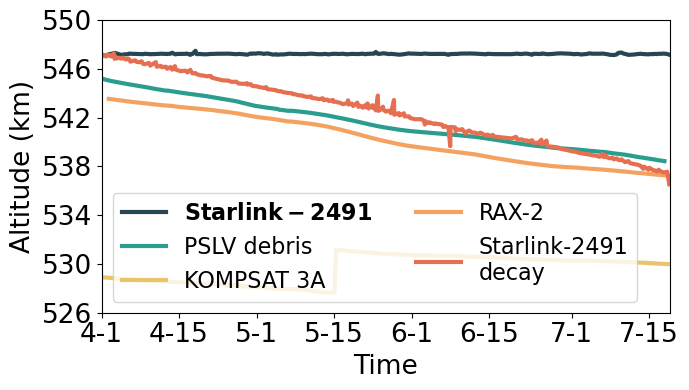

In [3]:
plt.figure(figsize=(7,4))
c=['#264653', '#2a9d8f', '#e9c46a', '#f4a261', '#e76f51',"#3F72AF","#112D4E"]
i=0
label=[r'$\bf{Starlink-2491}$','PSLV debris','KOMPSAT 3A','RAX-2','Starlink-2491\ndecay']
# label=['Starlink','PSLV debris','KOMPSAT 3A','RAX-2','Rocket body','OneWeb','Iridium']
# plt.ylim([526,548])

for key in data:
    item=data[key]
    plt.plot(item['EPOCH'],item['height'],label=label[i],c=c[i],lw=3)
    i+=1
plt.xlim(starttime,endtime)
plt.legend(fontsize=16,ncol=2)
plt.xlabel('Time',fontsize=19)
plt.ylabel('Altitude (km)',fontsize=19)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xticks([starttime,starttime+timedelta(days=15),starttime+timedelta(days=30),starttime+timedelta(days=45),starttime+timedelta(days=60),starttime+timedelta(days=75),starttime+timedelta(days=91),starttime+timedelta(days=106)],['4-1','4-15','5-1','5-15','6-1','6-15','7-1','7-15'])
plt.yticks(range(526,551,4),range(526,551,4))
plt.tight_layout()
plt.savefig('decay-case-v4.pdf')